# Predictive Bike-Sharing Pattern

Build a neural network to predict daily bike rental ridership.

This is the first project of the Deep Learning Nanodegree course by Udacity.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and Prepare Data

In [2]:
data_path = 'data/hour.csv'

rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


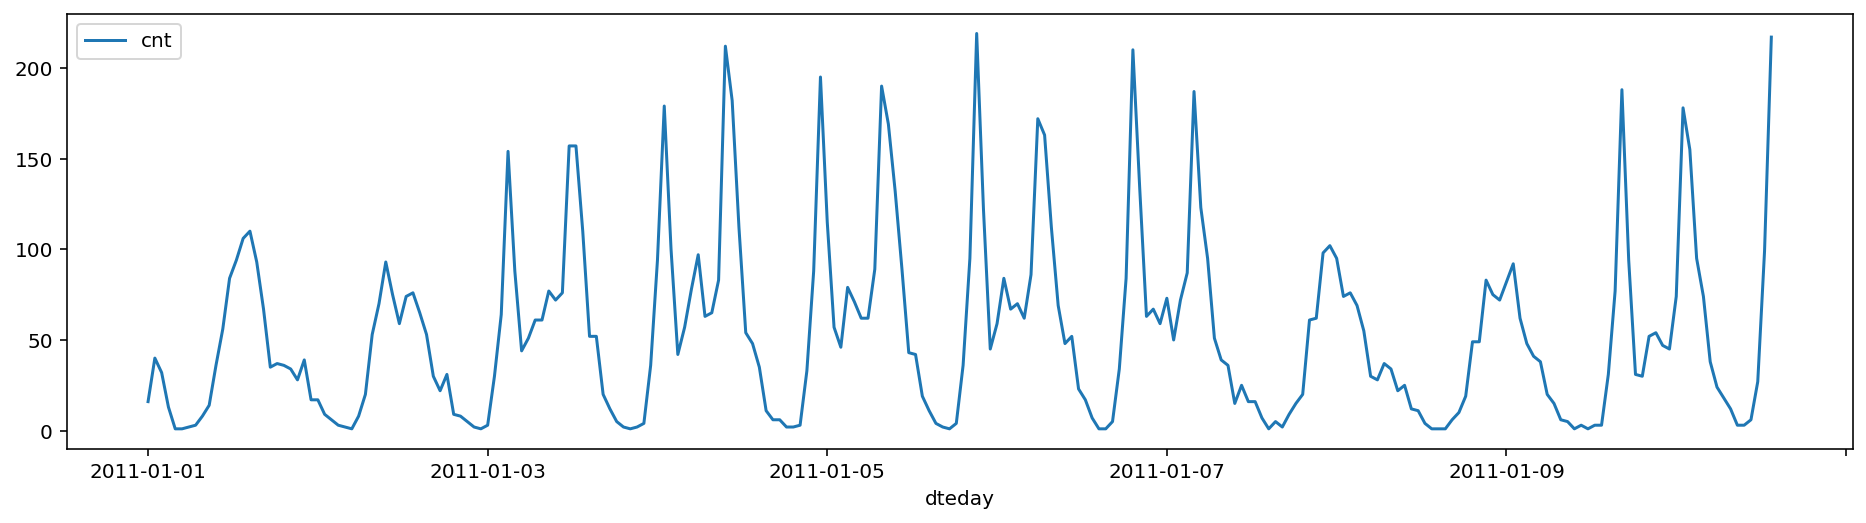

In [3]:
rides[:24*10].plot(x='dteday', y='cnt', figsize=(16, 4));

### One-Hot Encoding

Some categorical variables like season, weather, month shall be features of out model, hence we need to **one-hot encode** these variables:

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


## Normalization

We normalize each of the continuous variables. That is, we shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### Training, Testing, and Validation Sets

We split the 17379 records into **15435 training** records, **1440 validation** records and **504 testing** records.

In [6]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Neural Network

### The Model Class

In [12]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes ** -0.5, (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes ** -0.5, (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate

        # Sigmoid activation function
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))
        
    def train(self, features, targets):
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape) # shape: (3,2)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape) # shape: (2,1)
        
        for X, y in zip(features, targets):            
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o)
        
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)

    def forward_pass_train(self, X):
        # X.shape: (3,)
        # weights_input_to_hidden.shape: (3, 2)
        
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # shape: (2,)
        hidden_outputs = self.activation_function(hidden_inputs) # shape: (2,)

        # weights_hidden_to_output.shape: (2, 1)
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # shape: (1,)
        
        # activation function is identity function f(x) = x
        final_outputs = final_inputs # shape: (1,)
        
        return final_outputs, hidden_outputs

    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        # y.shape: (1,)
        # final_outputs.shape: (1,)
        # hidden_outputs.shape: (2,)
        
        error = y - final_outputs # shape: (1,)
        
        # the hidden layer's contribution to the error
        hidden_error = hidden_outputs * (1 - hidden_outputs) # shape: (2,)
        
        # ...
        output_error_term = error # shape: (1,)
        
        # ...
        hidden_error_term = output_error_term * self.weights_hidden_to_output * hidden_error[:,None] # shape: (2, 1)
                
        # Weight step (input to hidden)
        delta_weights_i_h += (hidden_error_term * X).T # shape: (3, 2)
        
        # Weight step (hidden to output)
        delta_weights_h_o += (output_error_term * hidden_outputs)[:, None] # shape: (2, 1)
        
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        self.weights_hidden_to_output += self.lr * (delta_weights_h_o / n_records)
        self.weights_input_to_hidden += self.lr * (delta_weights_i_h / n_records)

    def run(self, features):
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = None # signals into hidden layer
        hidden_outputs = None # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = None # signals into final output layer
        final_outputs = None # signals from final output layer 
        
        return final_outputs


#########################################################
# Set your hyperparameters here
##########################################################
iterations = 100
learning_rate = 0.1
hidden_nodes = 2
output_nodes = 1


In [13]:
inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
w_i_h = np.array([[0.1, -0.2], [0.4, 0.5], [-0.3, 0.2]])
w_h_o = np.array([[0.3], [-0.1]])
sigmoid = lambda x : 1 / (1 + np.exp(-x))

for X, y in zip(inputs, targets):
    h_1 = np.dot(X, w_i_h)
    print(h_1)
    
    fh_1 = sigmoid(h_1)
    print(fh_1)
    
    h_o = np.dot(fh_1, w_h_o)
    print(h_o)
    
    fh_o = h_o
    print(fh_o)
    
    error = y - fh_o
    print(error)
    
    hidden_error = fh_1 * (1 - fh_1)
    print(hidden_error.shape)
    
    output_error_term = -1
    print(output_error_term)
    
    delta_weights_h_o = output_error_term * fh_1
    print(delta_weights_h_o)
    
    print(w_h_o.shape)
    print(hidden_error[:,None].shape)
    hidden_error_term = output_error_term * w_h_o * hidden_error[:,None]
    print(hidden_error_term)
    
    delta_weights_i_h = (hidden_error_term * X).T
    print(delta_weights_i_h)

[-0.06 -0.18]
[0.4850045  0.45512111]
[0.09998924]
[0.09998924]
[0.30001076]
(2,)
-1
[-0.4850045  -0.45512111]
(2, 1)
(2, 1)
[[-0.07493254]
 [ 0.02479859]]
[[-0.03746627  0.01239929]
 [ 0.01498651 -0.00495972]
 [-0.00749325  0.00247986]]


In [14]:
inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])

network = NeuralNetwork(3, 2, 1, 0.5)
network.weights_input_to_hidden = np.array([[0.1, -0.2], [0.4, 0.5], [-0.3, 0.2]])
network.weights_hidden_to_output = np.array([[0.3], [-0.1]])

network.train(inputs, targets)

delta_weights_h_o: [[0.14550657]
 [0.13654123]]

delta_weights_i_h: [[ 0.01124028 -0.00371992]
 [-0.00449611  0.00148797]
 [ 0.00224806 -0.00074398]]

self.lr * (delta_weights_h_o / n_records): [[0.07275328]
 [0.06827061]]

self.lr * (delta_weights_i_h / n_records): [[ 0.00562014 -0.00185996]
 [-0.00224806  0.00074398]
 [ 0.00112403 -0.00037199]]

self.weights_hidden_to_output: [[ 0.3]
 [-0.1]]

self.weights_input_to_hidden: [[ 0.1 -0.2]
 [ 0.4  0.5]
 [-0.3  0.2]]

self.weights_hidden_to_output: [[ 0.37275328]
 [-0.03172939]]

self.weights_input_to_hidden: [[ 0.10562014 -0.20185996]
 [ 0.39775194  0.50074398]
 [-0.29887597  0.19962801]]



### Unit Test of the Model Class

In [16]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2], [0.4, 0.5], [-0.3, 0.2]])
test_w_h_o = np.array([[0.3], [-0.1]])

class TestMethods(unittest.TestCase):
    
    def test_data_path(self):
        self.assertTrue(data_path.lower() == 'data/hour.csv')
        
    def test_data_loaded(self):
        self.assertTrue(isinstance(rides, pd.DataFrame))

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, np.array([[ 0.37275328], [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden, np.array([[ 0.10562014, -0.20185996], [0.39775194, 0.50074398], [-0.29887597, 0.19962801]])))

#    def test_run(self):
#        network = NeuralNetwork(3, 2, 1, 0.5)
#        network.weights_input_to_hidden = test_w_i_h.copy()
#        network.weights_hidden_to_output = test_w_h_o.copy()

#        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

....

delta_weights_h_o: [[0.14550657]
 [0.13654123]]

delta_weights_i_h: [[ 0.01124028 -0.00371992]
 [-0.00449611  0.00148797]
 [ 0.00224806 -0.00074398]]

self.lr * (delta_weights_h_o / n_records): [[0.07275328]
 [0.06827061]]

self.lr * (delta_weights_i_h / n_records): [[ 0.00562014 -0.00185996]
 [-0.00224806  0.00074398]
 [ 0.00112403 -0.00037199]]

self.weights_hidden_to_output: [[ 0.3]
 [-0.1]]

self.weights_input_to_hidden: [[ 0.1 -0.2]
 [ 0.4  0.5]
 [-0.3  0.2]]

self.weights_hidden_to_output: [[ 0.37275328]
 [-0.03172939]]

self.weights_input_to_hidden: [[ 0.10562014 -0.20185996]
 [ 0.39775194  0.50074398]
 [-0.29887597  0.19962801]]




----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>